In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 17.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found

In [2]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
import re
import spacy
from transformers import CLIPProcessor, CLIPModel
from ultralytics import YOLO

2025-04-25 05:36:49.005956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745559409.191257      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745559409.241955      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
def parse_text_prompt(text):
    """
    Parse the text prompt to extract source object (optional), source color, and target color
    """
    doc = nlp(text.lower())

    source_color = None
    target_color = None
    target_object = None

    color_pattern = '|'.join(color_dict.keys())
    colors = re.findall(color_pattern, text.lower())

    # Handle "from X to Y" format more explicitly
    if "from" in text.lower() and "to" in text.lower():
        from_idx = text.lower().index("from")
        to_idx = text.lower().index("to")

        if from_idx < to_idx:
            for color in colors:
                color_idx = text.lower().find(color, from_idx)  # Start search from "from"
                if color_idx != -1:  # Make sure color was found
                    if from_idx < color_idx < to_idx:
                        source_color = color
                    elif color_idx > to_idx:
                        target_color = color
                        break  # First color after "to" is target color
    else:
        # If there are at least two colors mentioned, assume first is source, second is target
        if len(colors) >= 2:
            source_color = colors[0]
            target_color = colors[1]
        # If only one color, assume it's the target color
        elif len(colors) == 1:
            target_color = colors[0]

    # Extract object information - look for nouns that aren't colors
    for chunk in doc.noun_chunks:
        for token in chunk:
            if token.pos_ == "NOUN" and token.text.lower() not in color_dict and token.text.lower() != "color":
                target_object = token.text.lower()
                break
        if target_object:
            break

    if target_color and not source_color:
        if not target_object:
            raise ValueError("Specify an object if you're mentioning only the target color.")
        source_color = None

    return source_color, target_color, target_object

def detect_object(image_path, target_object=None):
    """
    Detect and locate the target object in the image using YOLOv8
    When target_object is None, returns None to indicate the entire image should be used
    """
    if isinstance(image_path, str):
        image_cv = cv2.imread(image_path)
        image_pil = Image.open(image_path).convert("RGB")
    else:
        image_cv = image_path
        image_pil = Image.fromarray(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    
    #entire image should be used
    if target_object is None:
        return None, image_cv
    
    # Run object detection
    results = detector(image_cv)
    
    # Process CLIP embeddings for target object
    text_inputs = clip_processor.tokenizer([f"a photo of a {target_object}"],
                                               padding=True, return_tensors="pt")
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    best_score = -float('inf')
    best_box = None
    
    # For each detected object, compare with target object using CLIP
    for det in results[0].boxes:
        # Get box coordinates
        x1, y1, x2, y2 = map(int, det.xyxy[0].tolist())
    
        # Ensure coordinates are within image bounds
        h, w = image_cv.shape[:2]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
    
        # Skip if box is invalid
        if x1 >= x2 or y1 >= y2:
            continue
    
        # Crop the region
        cropped_region = image_cv[y1:y2, x1:x2]
        if cropped_region.size == 0:
            continue
    
        # Convert to PIL and process for CLIP
        cropped_pil = Image.fromarray(cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB))
        image_inputs = clip_processor.image_processor(cropped_pil, return_tensors="pt")
    
        # Get image features and compute similarity
        with torch.no_grad():
            image_features = clip_model.get_image_features(**image_inputs)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            similarity = torch.sum(text_features * image_features, dim=1).item()
    
        # Update best box if this one is better
        if similarity > best_score:
            best_score = similarity
            best_box = (x1, y1, x2, y2)
    
    return best_box, image_cv

def segment_with_grabcut( image, box):
    """
    Use GrabCut algorithm to segment the object from the bounding box
    """
    if box is None:
        return None

    # Create mask initialized with zeros (background)
    mask = np.zeros(image.shape[:2], np.uint8)

    # Set the bounding box region to probable foreground
    x1, y1, x2, y2 = box
    mask[y1:y2, x1:x2] = cv2.GC_PR_FGD

    # Create temporary arrays for GrabCut
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Apply GrabCut
    rect = (x1, y1, x2-x1, y2-y1)
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Create a mask where sure and probable foreground are set to 1
    final_mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('bool')

    return final_mask

def create_color_mask( image, source_color, mask=None, tolerance=1.3):
    """
    Create a mask for the specified color within the object region
    Tolerance parameter controls how wide the color range is (higher = more inclusive)
    """
    # Convert to HSV for easier color manipulation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    if source_color == "red":
        # Special case for red which wraps around the hue circle
        lower1, upper1, _ = color_dict["red"]
        lower2, upper2 = red_high

        # Increase range based on tolerance
        lower1_expanded = np.array([max(0, lower1[0] - 10 * tolerance),
                                   max(0, lower1[1] - 20 * tolerance),
                                   max(0, lower1[2] - 20 * tolerance)], dtype=np.uint8)
        upper1_expanded = np.array([min(180, upper1[0] + 10 * tolerance),
                                   min(255, upper1[1] + 20 * tolerance),
                                   min(255, upper1[2] + 20 * tolerance)], dtype=np.uint8)

        lower2_expanded = np.array([max(0, lower2[0] - 10 * tolerance),
                                   max(0, lower2[1] - 20 * tolerance),
                                   max(0, lower2[2] - 20 * tolerance)], dtype=np.uint8)
        upper2_expanded = np.array([min(180, upper2[0] + 10 * tolerance),
                                   min(255, upper2[1] + 20 * tolerance),
                                   min(255, upper2[2] + 20 * tolerance)], dtype=np.uint8)

        # Create mask for both red ranges
        mask1 = cv2.inRange(hsv_image, lower1_expanded, upper1_expanded)
        mask2 = cv2.inRange(hsv_image, lower2_expanded, upper2_expanded)
        color_mask = cv2.bitwise_or(mask1, mask2)
    else:
        # For other colors, create a single range
        lower, upper, _ = color_dict[source_color]

        # Increase range based on tolerance
        lower_expanded = np.array([max(0, lower[0] - 10 * tolerance),
                                  max(0, lower[1] - 20 * tolerance),
                                  max(0, lower[2] - 20 * tolerance)], dtype=np.uint8)
        upper_expanded = np.array([min(180, upper[0] + 10 * tolerance),
                                  min(255, upper[1] + 20 * tolerance),
                                  min(255, upper[2] + 20 * tolerance)], dtype=np.uint8)

        # Create mask for the color range
        color_mask = cv2.inRange(hsv_image, lower_expanded, upper_expanded)

    # Convert to boolean
    color_mask = color_mask.astype(bool)

    # If object mask is provided, restrict color mask to object area
    if mask is not None:
        color_mask = np.logical_and(color_mask, mask)

    return color_mask

def transform_color( image, color_mask, target_color):
    """
    Transform the color of the masked regions to the target color
    Preserves brightness and saturation variations for a natural look
    """
    # If no pixels to transform, return original image
    if not np.any(color_mask):
        return image

    # Get the target hue
    _, _, target_hue = color_dict[target_color]

    # Convert image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)

    # Extract channels
    h, s, v = cv2.split(hsv_image)

    # Replace hue in the masked area
    h[color_mask] = target_hue

    # Reconstitute HSV image
    hsv_transformed = cv2.merge([h, s, v])
    hsv_transformed = hsv_transformed.astype(np.uint8)

    # Convert back to BGR
    result = cv2.cvtColor(hsv_transformed, cv2.COLOR_HSV2BGR)

    return result

def detect_dominant_color( image, mask):
    """
    Detect the dominant color of the object within the mask
    Returns the color name from color_dict that best matches
    """
    # Convert to HSV for easier color analysis
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Apply mask to get only pixels from the object
    masked_hsv = hsv_image.copy()
    masked_hsv[~mask] = [0, 0, 0]  # Set non-object pixels to black
    
    # Get non-zero pixels (object pixels)
    non_zero_pixels = masked_hsv[mask]
    
    if len(non_zero_pixels) == 0:
        return None
    
    # Calculate average HSV values
    avg_h = np.mean(non_zero_pixels[:, 0])
    avg_s = np.mean(non_zero_pixels[:, 1])
    avg_v = np.mean(non_zero_pixels[:, 2])
    
    # Special case for low saturation colors (white, black, gray)
    if avg_s < 30:
        if avg_v > 200:
            return "white"
        elif avg_v < 50:
            return "black"
        else:
            return "gray"
    
    # Find the closest color in the color dictionary
    best_match = None
    min_distance = float('inf')
    
    for color_name, (lower, upper, hue) in color_dict.items():
        # Skip achromatic colors (already handled)
        if color_name in ["white", "black", "gray"]:
            continue
        
        # Calculate distance to this color's hue
        # Handle the circular nature of hue
        hue_dist = min(abs(avg_h - hue), 180 - abs(avg_h - hue))
        
        if hue_dist < min_distance:
            min_distance = hue_dist
            best_match = color_name
    
    # Special case for red which wraps around
    if (avg_h <= 10 or avg_h >= 170) and avg_s >= 50:
        best_match = "red"
    
    return best_match

def process_image( image_path, text_prompt):
    """
    Main method to transform colors in an image based on text prompt
    """
    # Parse the text prompt
    source_color, target_color, target_object = parse_text_prompt(text_prompt)

    if not target_color:
        raise ValueError("Could not identify target color from the prompt")

    # Detect the target object if specified
    if target_object:
        box, image = detect_object(image_path, target_object)
        if box is None:
            raise ValueError(f"Could not find '{target_object}' in the image")
        # Create a mask for the object
        object_mask = segment_with_grabcut(image, box)

        if not source_color:
            detected_color = detect_dominant_color(image, object_mask)
            if not detected_color:
                raise ValueError(f"Could not determine the dominant color of the {target_object}")
            source_color = detected_color
            print(f"Detected dominant color of {target_object}: {source_color}")
    
    else:
        # If no object specified, load the image and use the entire image
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
        else:
            image = image_path
        # Create a mask covering the entire image
        object_mask = np.ones(image.shape[:2], dtype=bool)

    print(f"Detected instruction: Change '{source_color}' to '{target_color}'{' in ' + target_object if target_object else ' in the whole image'}")

    # Create a mask for the specified color within the object or whole image
    color_mask = create_color_mask(image, source_color, object_mask, tolerance=1.5)

    if not np.any(color_mask):
        raise ValueError(f"Could not find '{source_color}' {f'in the {target_object}' if target_object else 'in the image'}")

    # Transform the color
    result = transform_color(image, color_mask, target_color)

    return result, color_mask, image
def display_result( result, color_mask, original_image):
    """
    Display the original and modified images side by side with the color mask
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(color_mask, cmap='gray')
    plt.title("Color Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Color Transformed Result")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
"""
Initialize the color transformation system
"""
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
detector = YOLO("yolov8x.pt")

nlp = spacy.load("en_core_web_sm")

# Color definitions in HSV format (easier for color transforms)
# Format: [hue_min, hue_max, default_hue]

#claude
color_dict = {
    "red": [np.array([0, 50, 50]), np.array([10, 255, 255]), 0],
    "orange": [np.array([10, 50, 50]), np.array([25, 255, 255]), 15],
    "yellow": [np.array([25, 50, 50]), np.array([35, 255, 255]), 30],
    "green": [np.array([35, 50, 50]), np.array([85, 255, 255]), 60],
    "cyan": [np.array([85, 50, 50]), np.array([95, 255, 255]), 90],
    "blue": [np.array([95, 50, 50]), np.array([135, 255, 255]), 120],
    "purple": [np.array([135, 50, 50]), np.array([155, 255, 255]), 145],
    "magenta": [np.array([155, 50, 50]), np.array([170, 255, 255]), 160],
    "pink": [np.array([170, 50, 50]), np.array([180, 255, 255]), 175],
    "brown": [np.array([5, 50, 50]), np.array([15, 255, 255]), 10],
    "black": [np.array([0, 0, 0]), np.array([180, 50, 50]), 0],
    "white": [np.array([0, 0, 200]), np.array([180, 30, 255]), 0],
    "gray": [np.array([0, 0, 70]), np.array([180, 30, 200]), 0],
}

#chatGPT
# color_dict = {
#     "red":    [np.array([0, 150, 100]),   np.array([10, 255, 255]), 0],
#     "orange": [np.array([11, 150, 100]),  np.array([20, 255, 255]), 15],
#     "yellow": [np.array([21, 150, 100]),  np.array([30, 255, 255]), 25],
#     "green":  [np.array([35, 100, 100]),  np.array([85, 255, 255]), 60],
#     "cyan":   [np.array([86, 100, 100]),  np.array([95, 255, 255]), 90],
#     "blue":   [np.array([96, 150, 100]),  np.array([130, 255, 255]), 115],
#     "purple": [np.array([131, 150, 100]), np.array([150, 255, 255]), 140],
#     "pink":   [np.array([151, 100, 150]), np.array([170, 255, 255]), 160],
#     "brown":  [np.array([10, 150, 50]),   np.array([20, 255, 180]), 15],
#     "black":  [np.array([0, 0, 0]),       np.array([180, 255, 50]), 0],
#     "gray":   [np.array([0, 0, 51]),      np.array([180, 50, 200]), 0],
#     "white":  [np.array([0, 0, 201]),     np.array([180, 50, 255]), 0],
# }

#manual
# color_dict = {
#         "red": [np.array([170, 255, 210]), np.array([6, 255, 255]), 0],
#         "orange": [np.array([7, 255, 255]), np.array([20, 255, 255]), 15],
#         "yellow": [np.array([22, 255, 255]), np.array([32, 255, 255]), 30],
#         "green": [np.array([45, 255, 200]), np.array([75, 255, 255]), 60],
#         "blue": [np.array([115, 255, 255]), np.array([130, 255, 255]), 120],
#         "purple": [np.array([130, 255, 255]), np.array([145, 255, 255]), 135],
#         "pink": [np.array([150, 255, 255]), np.array([170, 255, 255]), 155],
#         "brown": [np.array([7, 255, 130]), np.array([15, 255, 210]), 15],
#         "black": [np.array([0, 0, 30]), np.array([0, 0, 50]), 0],
#         "white": [np.array([0, 0, 230]), np.array([0, 0, 255]), 0],
#         "gray": [np.array([0, 0, 70]), np.array([0, 0, 200]), 0],
# }


# Special case for red which wraps around the hue circle
red_high = [np.array([170, 50, 50]), np.array([180, 255, 255])]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]


  0%|          | 0.00/131M [00:00<?, ?B/s]
 11%|█         | 14.1M/131M [00:00<00:00, 148MB/s]
 31%|███▏      | 41.0M/131M [00:00<00:00, 226MB/s]
 51%|█████     | 66.4M/131M [00:00<00:00, 244MB/s]
 73%|███████▎  | 95.6M/131M [00:00<00:00, 268MB/s]
100%|██████████| 131M/131M [00:00<00:00, 262MB/s] 



0: 640x640 2 elephants, 96.7ms
Speed: 2.4ms preprocess, 96.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Detected dominant color of elephants: orange
Detected instruction: Change 'orange' to 'blue' in elephants


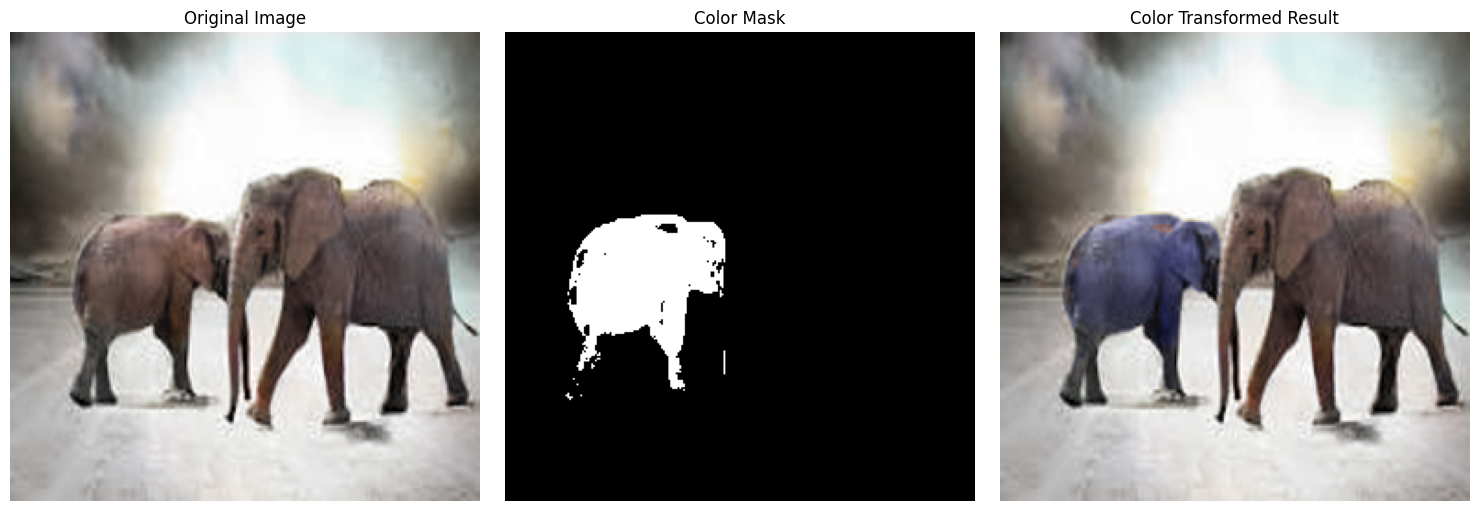

In [19]:
# show_full_hsv_ranges(color_dict)

image_path = "/kaggle/input/testing/2.png"
text_prompt = "elephants to blue"

result, color_mask, original = process_image(image_path, text_prompt)

display_result(result, color_mask, original)

#cv2.imwrite("color_transformed_result.jpg", result)